<a href="https://colab.research.google.com/github/Latamila/ConsumoEnergiaSerieTemporal/blob/main/Projeto1_parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from platform import python_version
print('versão: ', python_version())

versão:  3.10.12


In [2]:
!pip install -q tensorflow

In [3]:
!pip install -q keras

In [4]:
# Define variável de ambiente para slienciar as mensagens do TF
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [5]:
# Imports
import sklearn
import statsmodels
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Formatando as saídas dos gráficos
plt.style.use('fivethirtyeight')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'

In [8]:
!pip install watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.7 MB/s eta 0:00:00


In [9]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

keras      : 2.15.0
pandas     : 1.5.3
sklearn    : 1.2.2
tensorflow : 2.15.0
matplotlib : 3.7.1
statsmodels: 0.14.1
seaborn    : 0.12.2
numpy      : 1.23.5



In [12]:
# Carrega o dataset
df = pd.read_csv('dataset.csv')

In [13]:
df.head()

,Mes,Vendas
0,01-01-2016,14057
1,02-01-2016,15475
2,03-01-2016,14524
3,04-01-2016,15661
4,05-01-2016,12355


In [14]:
df.tail()

,Mes,Vendas
70,11-01-2021,14568
71,12-01-2021,15661
72,01-01-2022,19108
73,02-01-2022,19202
74,03-01-2022,13623


<Axes: >

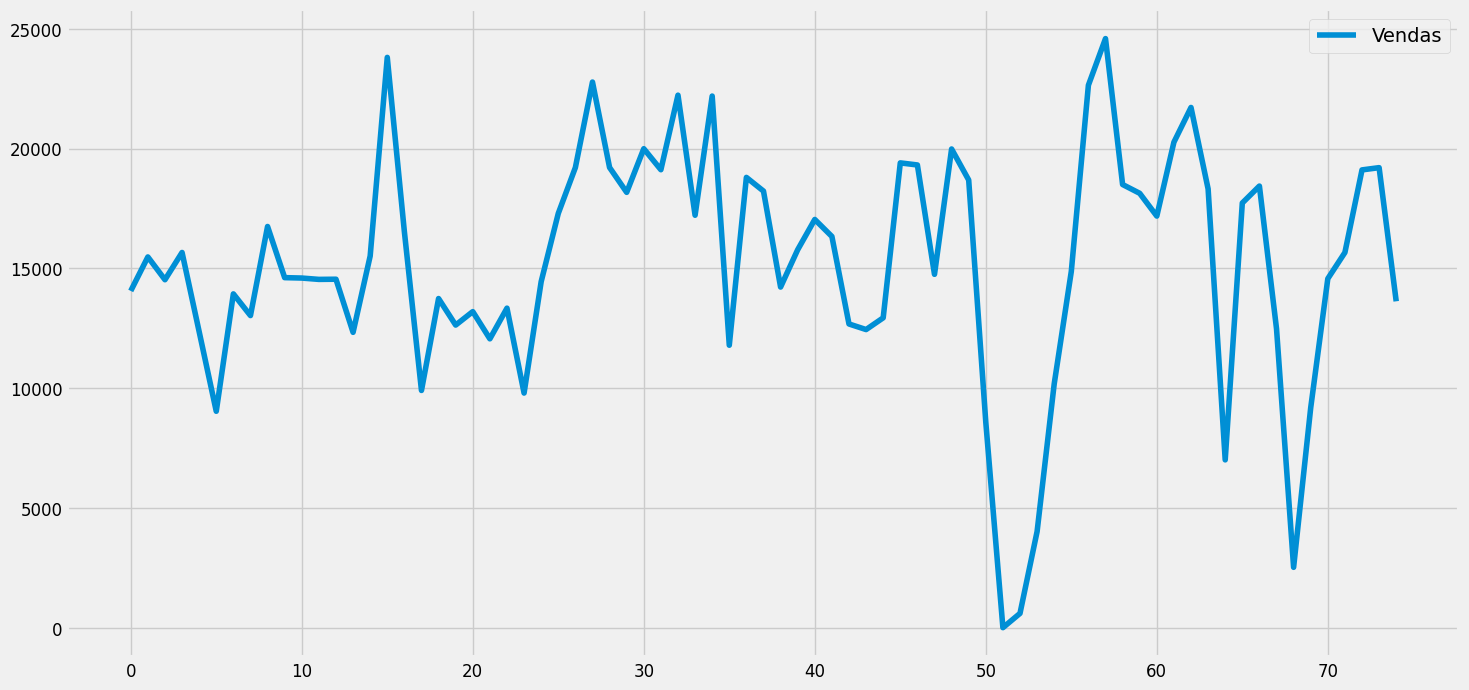

In [15]:
df.plot(figsize = (16,8))

In [16]:
df.head(6)

,Mes,Vendas
0,01-01-2016,14057
1,02-01-2016,15475
2,03-01-2016,14524
3,04-01-2016,15661
4,05-01-2016,12355
5,06-01-2016,9033


In [17]:
#media
df['Vendas'].mean()

15189.32

In [18]:
df.describe()

,Vendas
count,75.000000
mean,15189.320000
std,4938.414767
min,0.000000
25%,12805.500000
50%,15475.000000
75%,18592.000000
max,24589.000000


## TRATAMENTO DE OUTLIERS



In [21]:
#extrai o percentil 10
min_threshold = df['Vendas'].quantile(0.10)

In [22]:
min_threshold

9425.2

In [23]:
amostra =  df[df['Vendas'] < min_threshold]

In [24]:
amostra


,Mes,Vendas
5,06-01-2016,9033
50,03-01-2020,8575
51,04-01-2020,0
52,05-01-2020,597
53,06-01-2020,4013
64,05-01-2021,7005
68,09-01-2021,2520
69,10-01-2021,9180


In [25]:
df.count()

Mes       75
Vendas    75
dtype: int64

In [26]:
#interpolacao
#qualquer valor abaixo do min_threshold será substituido pela media
for i in range(75):
  if df.loc[i, 'Vendas'] < 9425.2:
    df.iat[i,1] = 15190

No pandas, iat é um método que permite acessar um único valor em um DataFrame ou Series, com base em sua posição numérica. Ele é semelhante ao método iloc, mas é otimizado para acesso a valores individuais, tornando-o mais rápido do que o iloc em casos em que é necessário acessar um único valor.

O iat tem a sintaxe iat[i, j], onde i e j são as posições numéricas do índice e da coluna, respectivamente.


O iat pode ser útil em situações em que é necessário acessar um único valor em um DataFrame ou Series grande, porque ele é muito mais rápido do que a indexação normal usando chaves ou o método loc, que são projetados para acessar múltiplos valores simultaneamente. No entanto, como o iat acessa valores com base em sua posição numérica, é importante garantir que a ordem dos índices e colunas seja consistente em todo o DataFrame ou Series, para que o valor correto seja acessado.

In [27]:
df.head(6)

,Mes,Vendas
0,01-01-2016,14057
1,02-01-2016,15475
2,03-01-2016,14524
3,04-01-2016,15661
4,05-01-2016,12355
5,06-01-2016,15190


In [28]:
df.describe()

,Vendas
count,75.000000
mean,16263.946667
std,3296.759957
min,9793.000000
25%,14137.500000
50%,15475.000000
75%,18592.000000
max,24589.000000


In [29]:
#converte a coluna mes para o tipo datetime
df['Mes'] = pd.to_datetime(df['Mes'])

In [30]:
#define o mes como indice
df.set_index('Mes', inplace = True)

In [31]:
df.head(6)

,Vendas
Mes,
2016-01-01,14057
2016-02-01,15475
2016-03-01,14524
2016-04-01,15661
2016-05-01,12355
2016-06-01,15190


<Axes: xlabel='Mes'>

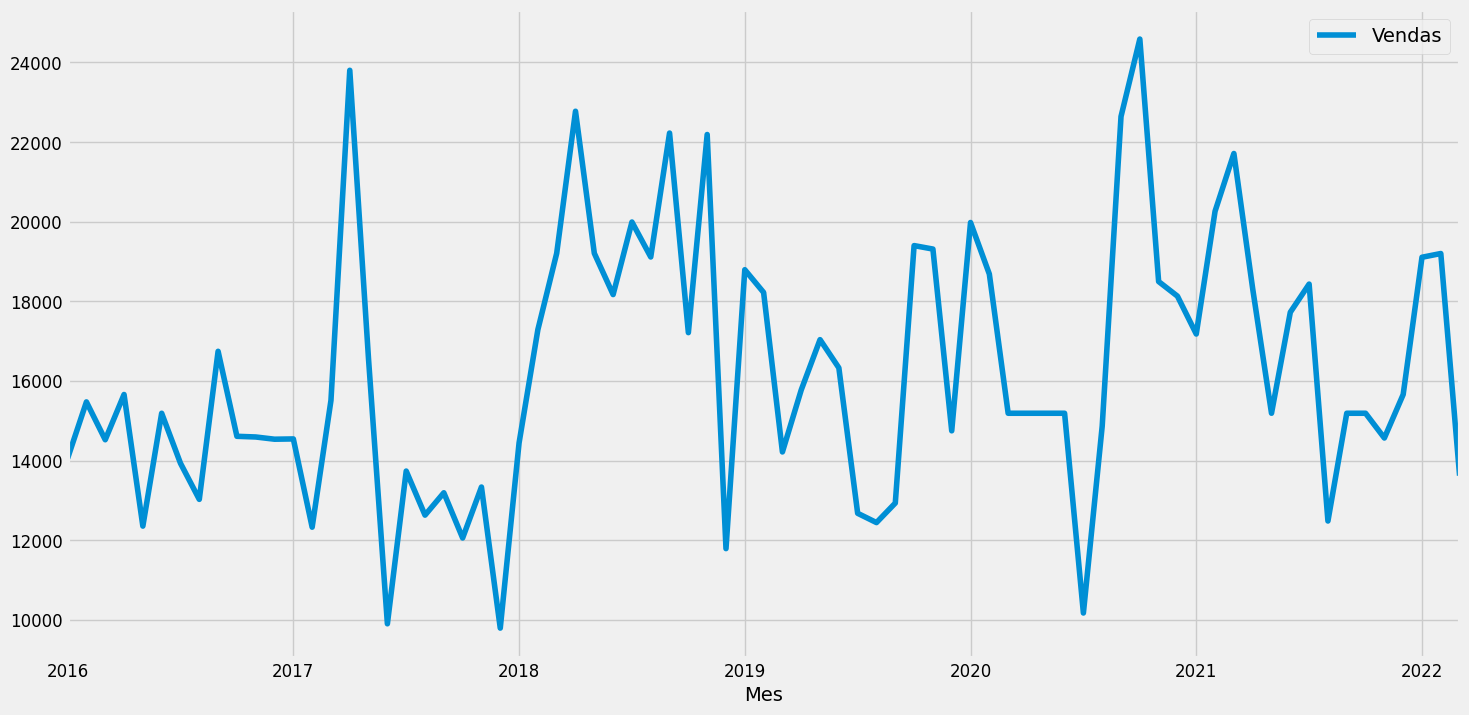

In [32]:
df.plot(figsize = (16,8))

## DECOMPOSIÇÃO DA SERIE TEMPORAL

O seasonal_decompose é uma função do pacote statsmodels em python que permite decompor uma serie temporal em suas componentes:

tendencia, sazonalidade e residuo.

A decomposição de uma serie temporal em suas componentes é uma tecnica util para analise de series temporais, pois ajuda a entender melhor o comportamento da serie e identificar padrões.

O seasonal_decompose usa um modelo aditivo ou multiplicativo para desagregar a serie temporal em suas componentes. O modelo aditivo assume que a serie é a soma de sua tendencia, sazonalidade e residuo, enquanto o modelo multiplicativo assume que a serie é o produto de suas componentes.

Em seguida, a função calcula a media movel da serie temporal e subtrai da serie original para obter a tendencia. depois, a função calcula a media das saszonalidades em cada periodo e subtrai da serie para obter a componente sazonal. Por fim, a função calcula a diferença entre a serie original e as componentes da tendencia e sazonalidade para obter o residuo.

O seasonal_decompose é util porque permite visualizar e entender melhor o comportamento da serie temporal, identificando tendencias e padroes sazonais que podem ser uteis para previsoes futuras. Alem disso, a função ajuda a detectar anomalias e outliers na serie, permitindo identificar eventos incomuns que podem afetar a analise e previsão.

In [34]:
#decomposição

resultado = seasonal_decompose(df['Vendas'])

In [35]:
plt.rcParams.update({'figure.figsize':(16,10)})

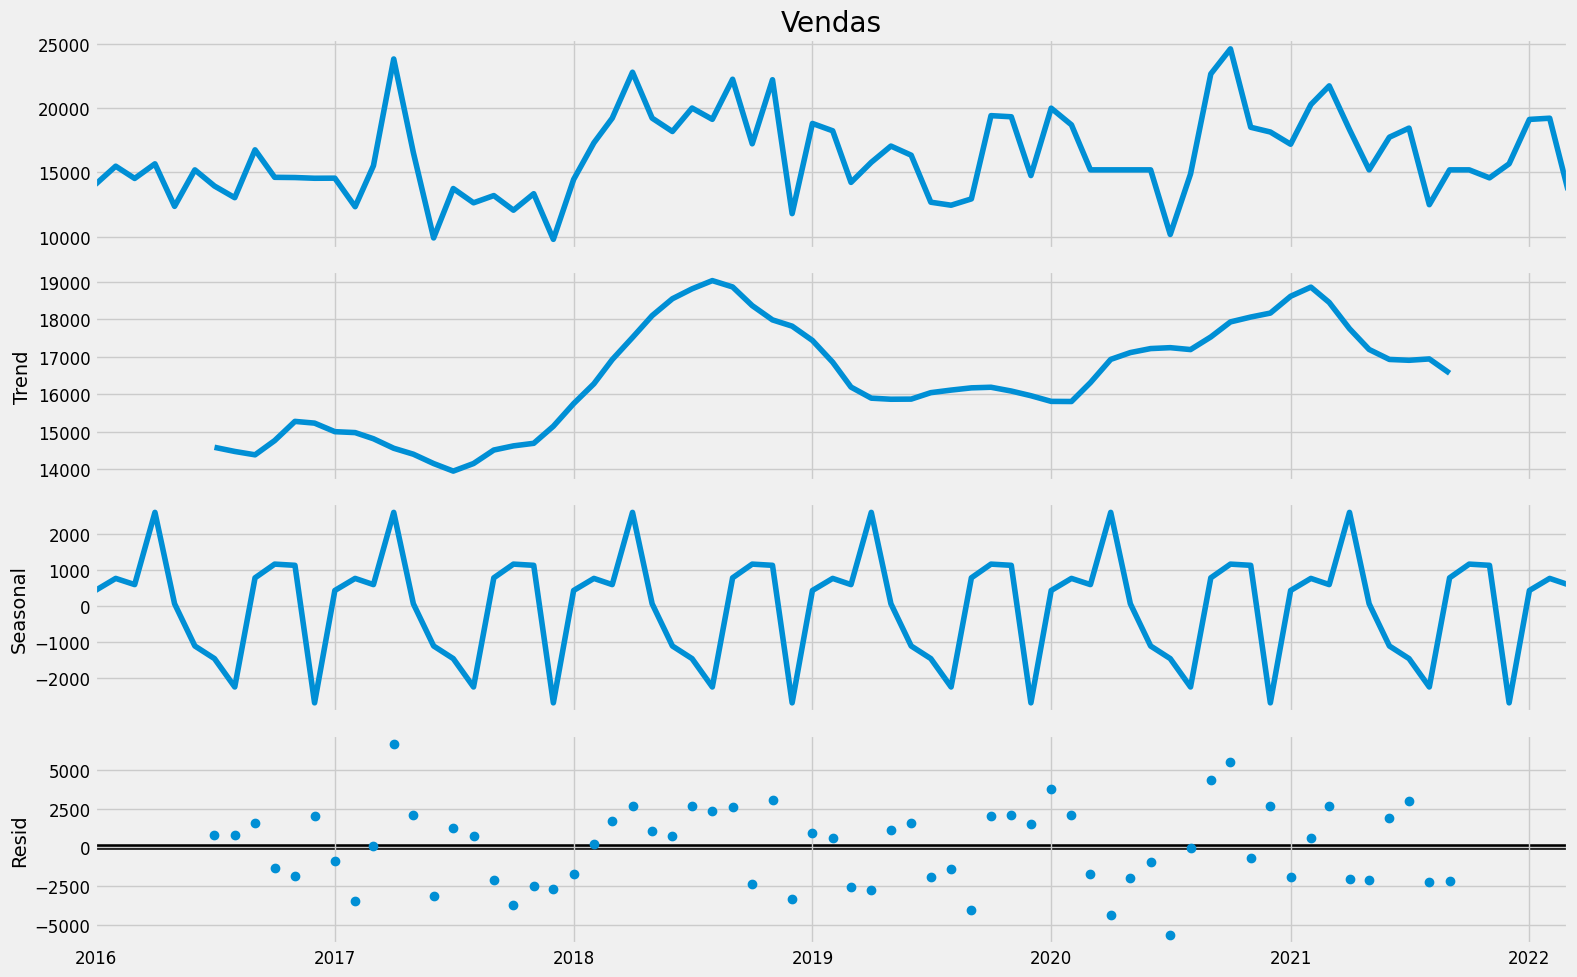

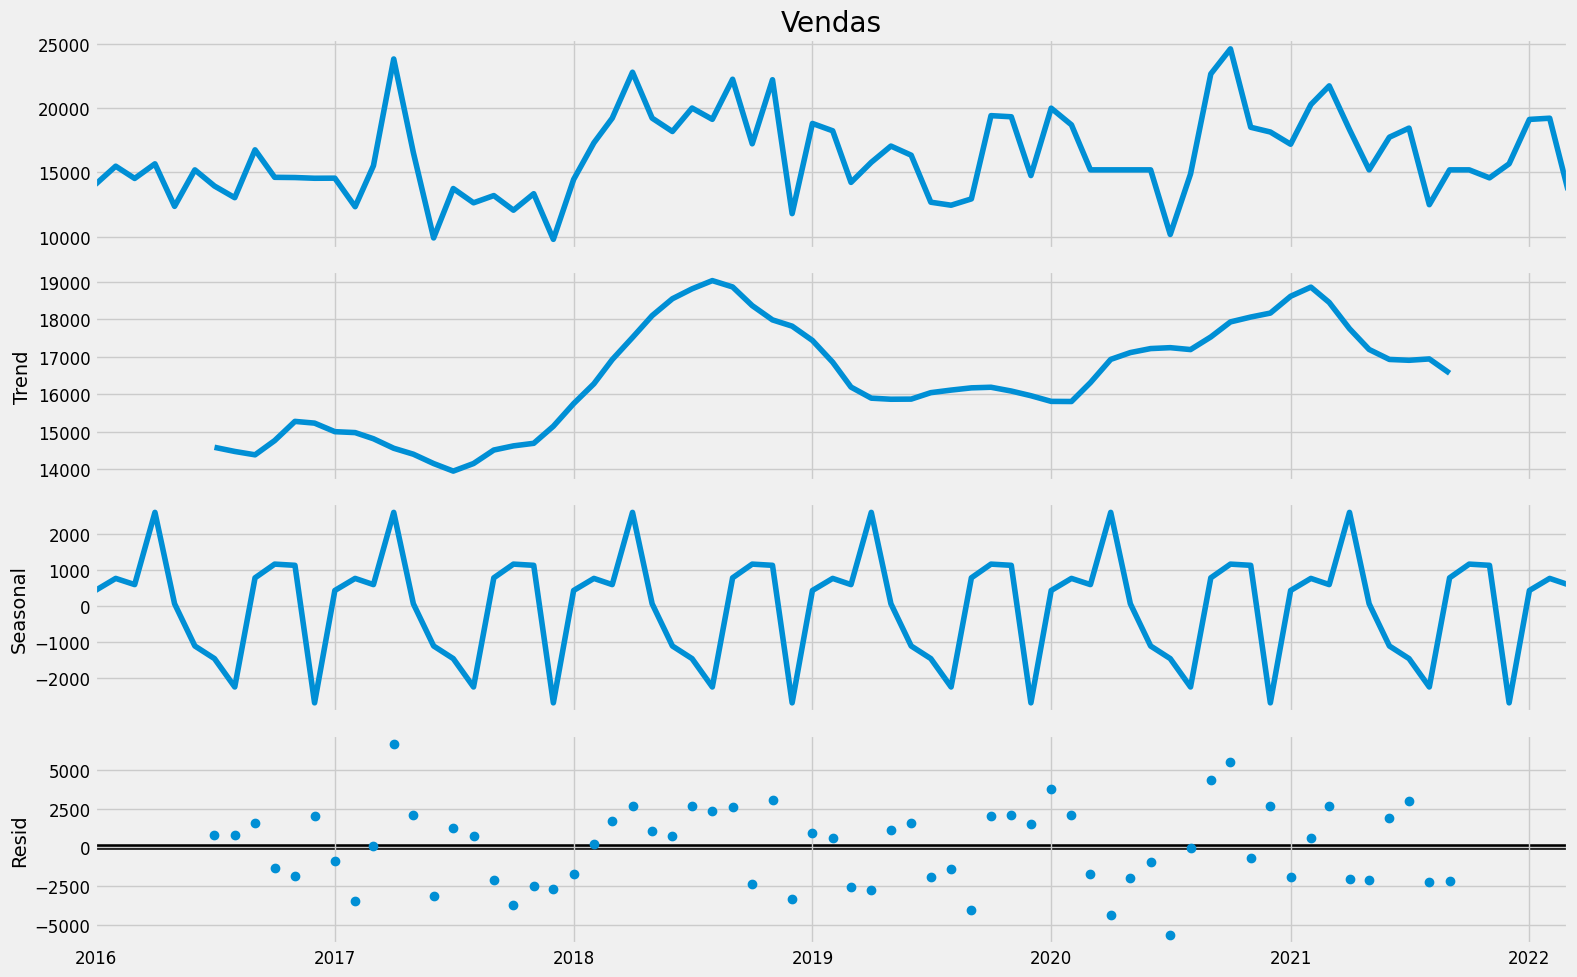

In [36]:
resultado.plot()

In [37]:
#TESTANDO A ESTACIONARIDADE DA SERIE

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [38]:
%reload_ext watermark
%watermark -a 'Camila' --iversions

Author: Camila

keras      : 2.15.0
pandas     : 1.5.3
sklearn    : 1.2.2
tensorflow : 2.15.0
matplotlib : 3.7.1
statsmodels: 0.14.1
seaborn    : 0.12.2
numpy      : 1.23.5



In [39]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):

    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')

    # Plot
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()

    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)

    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

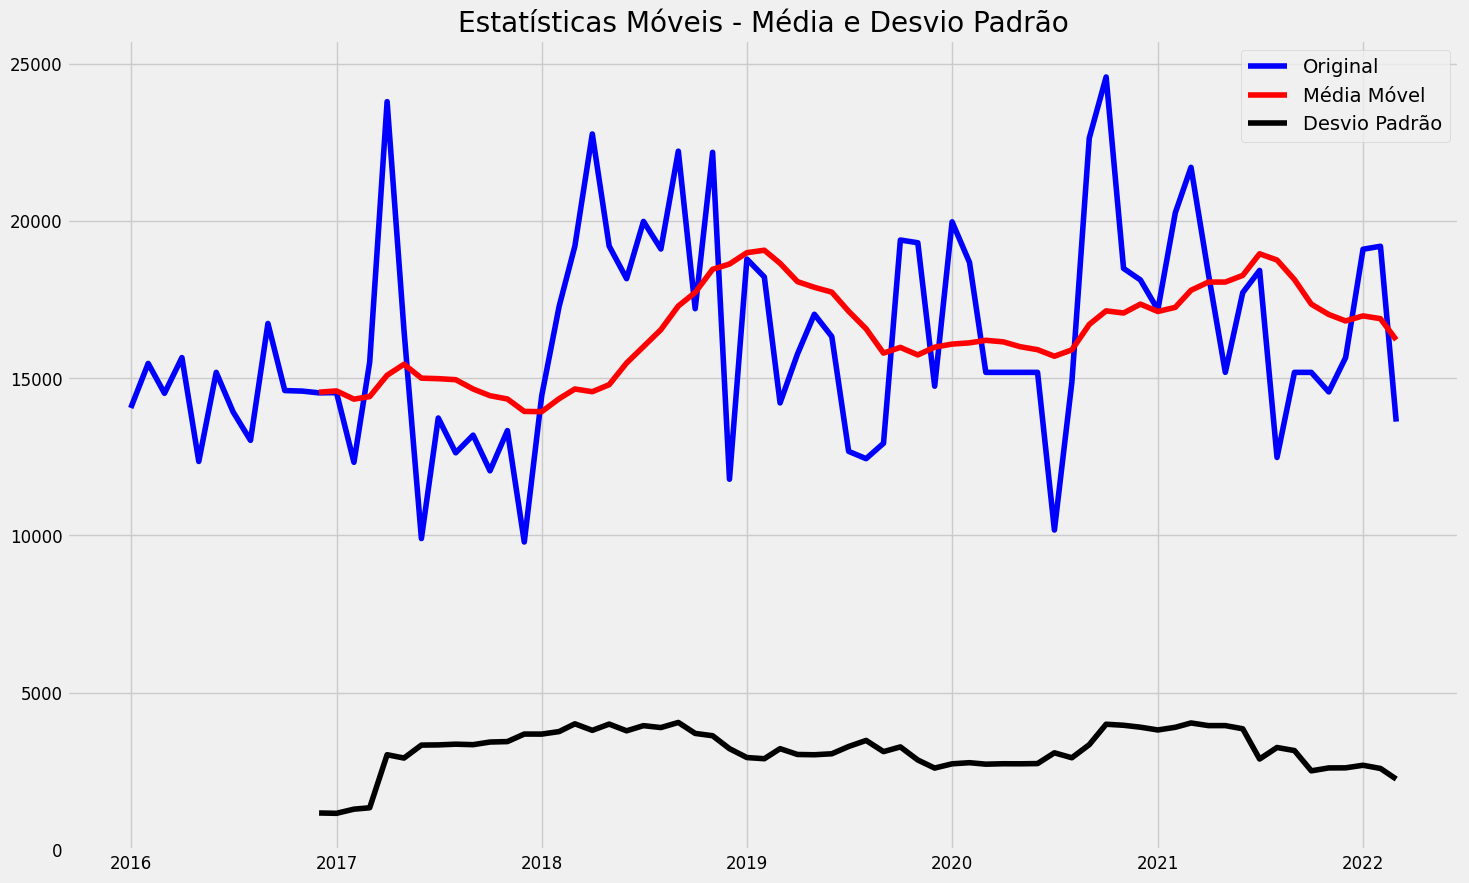


Resultado do Teste Dickey-Fuller:

Estatística do Teste            -5.520051
Valor-p                          0.000002
Número de Lags Consideradas      0.000000
Número de Observações Usadas    74.000000
Valor Crítico (1%)              -3.521980
Valor Crítico (5%)              -2.901470
Valor Crítico (10%)             -2.588072
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [40]:
# Vamos testar a estacionaridade da série antes de qualquer transformação
plt.rcParams.update({'figure.figsize': (16,10)})
testa_estacionaridade(df)

In [41]:
#divisao em treino e teste e padronização
len(df)

75

In [42]:
# Divisão em treino e teste
dados_treino = df.iloc[:63]
dados_teste = df.iloc[63:]

# Cria o padronizador
scaler = MinMaxScaler()

# Fit com dados de treino
scaler.fit(dados_treino)

# Transform em treino e teste
scaled_treino = scaler.transform(dados_treino)
scaled_teste = scaler.transform(dados_teste)

scaled_treino[:10]

array([[0.288186  ],
       [0.38402271],
       [0.31974858],
       [0.39659367],
       [0.17315491],
       [0.36476075],
       [0.27987294],
       [0.21857259],
       [0.4699243 ],
       [0.32562855]])

## Pré-Processamento da Série Temporal com TimeseriesGenerator


TimeseriesGenerator do Keras é uma classe que permite gerar sequências de dados de séries temporais para uso em modelos de redes neurais. Ele é útil para problemas de aprendizado de máquina envolvendo previsão de séries temporais, como previsão de valores futuros de ações, previsão de demanda de energia, previsão de preços de commodities, entre outros.

O TimeseriesGenerator divide uma série temporal em sequências menores, criando uma janela deslizante de observações. Isso significa que, para cada sequência, ele seleciona um intervalo de observações e as usa como entrada para o modelo de rede neural, com o objetivo de prever o próximo valor da série temporal.

O TimeseriesGenerator oferece várias opções de configuração, como o comprimento das sequências, o espaçamento entre elas, o número de recursos, a função de normalização e a possibilidade de embaralhar as sequências antes do treinamento.

Ele é útil porque simplifica o processo de pré-processamento e preparação de dados, tornando-o mais fácil e rápido. Além disso, o TimeseriesGenerator é compatível com uma variedade de modelos de redes neurais, permitindo que os usuários experimentem diferentes arquiteturas de modelos para encontrar a que melhor se adapta ao problema em questão.

In [43]:
# Janela de previsão que o modelo será treinado.
#Esse objeto sera mudado para melhorar o modelo caso necessario.
n_input = 6

In [44]:
# Cria o generator
generator = TimeseriesGenerator(scaled_treino, scaled_treino, length = n_input, batch_size = 1)

In [45]:
X,y = generator[0]

In [46]:
X.shape

(1, 6, 1)

In [47]:
y.shape


(1, 1)

In [48]:
print(f'\nArray de Entrada (x): \n{X.flatten()}')
print(f'\nPrevisão (y): \n {y}')


Array de Entrada (x): 
[0.288186   0.38402271 0.31974858 0.39659367 0.17315491 0.36476075]

Previsão (y): 
 [[0.27987294]]


## MODELAGEM

A arquitetura LSTM (Long Short-Term Memory) é um tipo de rede neural recorrente (RNN) que foi projetada para resolver o problema do gradiente desvanecente (vanishing gradient) em redes neurais tradicionais. As LSTMs foram introduzidas por Hochreiter e Schmidhuber em 1997, e se tornaram amplamente utilizadas em tarefas de processamento de linguagem natural, reconhecimento de fala, previsão de séries temporais, entre outros.

As LSTMs são compostas por unidades de memória, chamadas células LSTM, que possuem um estado de memória interno que é atualizado e modulado por três portões:

##*o portão de entrada (input gate), o portão de esquecimento (forget gate) e o portão de saída (output gate). **

Esses portões permitem que as LSTMs aprendam e retenham informações relevantes por períodos prolongados de tempo e esqueçam informações irrelevantes.

O portão de entrada controla a atualização do estado da célula com base nas novas entradas. O portão de esquecimento decide quais informações da célula antiga devem ser mantidas ou esquecidas. E o portão de saída controla a saída da célula, modulando o estado atual da célula. Todos esses portões são controlados por funções de ativação, que determinam a quantidade de informação que deve ser mantida, esquecida ou atualizada.

A arquitetura LSTM pode ser usada para previsão de séries temporais, classificação de texto, tradução automática, reconhecimento de fala, entre outras tarefas de aprendizado de máquina. Devido à sua habilidade em lidar com dependências de longo prazo, as LSTMs são particularmente úteis em tarefas que exigem a compreensão de sequências complexas de dados.


In [49]:
n_features = 1
#numero de atributos


A definição do número de neurônios em um modelo LSTM criado com o Keras depende do problema que você está tentando resolver e da quantidade de dados que você tem disponível para treinar o modelo. Em geral, um número maior de neurônios pode levar a um modelo mais complexo e capaz de aprender relações mais complexas nos dados, mas pode levar a problemas de overfitting se a quantidade de dados disponíveis for insuficiente para treinar o modelo adequadamente.

Aqui estão algumas diretrizes gerais para ajudá-lo a escolher o número de neurônios em um modelo LSTM:

- Comece com uma quantidade menor de neurônios e vá aumentando gradualmente até que o modelo atinja um bom desempenho nos dados de treinamento e de teste. Observe que o aumento do número de neurônios também aumentará o tempo de treinamento do modelo.


- Use métodos de regularização, como dropout ou L2, para ajudar a prevenir o overfitting do modelo.


- Considere o número de timesteps e de variáveis de entrada no seu conjunto de dados. Em geral, um número maior de timesteps e de variáveis pode exigir um número maior de neurônios para que o modelo seja capaz de capturar relações complexas nos dados.


- Experimente diferentes números de neurônios e observe o desempenho do modelo em um conjunto de validação. Escolha o número de neurônios que resulta no melhor desempenho no conjunto de validação.

In [50]:
# Modelo
modelo = Sequential()
modelo.add(LSTM(200, activation = 'relu', input_shape = (n_input, n_features)))
modelo.add(Dense(1))
modelo.compile(optimizer = 'adam', loss = 'mse')

In [51]:
# Sumário
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 161801 (632.04 KB)
Trainable params: 161801 (632.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
# Treinamento
modelo.fit(generator, epochs = 200)

Epoch 1/200
57/57 [==============================] - 5s 13ms/step - loss: 0.0996
Epoch 2/200
57/57 [==============================] - 0s 8ms/step - loss: 0.0614
Epoch 3/200
57/57 [==============================] - 0s 8ms/step - loss: 0.0551
Epoch 4/200
57/57 [==============================] - 0s 8ms/step - loss: 0.0650
Epoch 5/200
57/57 [==============================] - 1s 9ms/step - loss: 0.0565
Epoch 6/200
57/57 [==============================] - 1s 9ms/step - loss: 0.0582
Epoch 7/200
57/57 [==============================] - 1s 9ms/step - loss: 0.0535
Epoch 8/200
57/57 [==============================] - 1s 9ms/step - loss: 0.0563
Epoch 9/200
57/57 [==============================] - 0s 8ms/step - loss: 0.0581
Epoch 10/200
57/57 [==============================] - 0s 8ms/step - loss: 0.0572
Epoch 11/200
57/57 [==============================] - 0s 8ms/step - loss: 0.0550
Epoch 12/200
57/57 [==============================] - 0s 8ms/step - loss: 0.0572
Epoch 13/200
57/57 [================

In [53]:
# Erro por epoch
loss_per_epoch = modelo.history.history['loss']

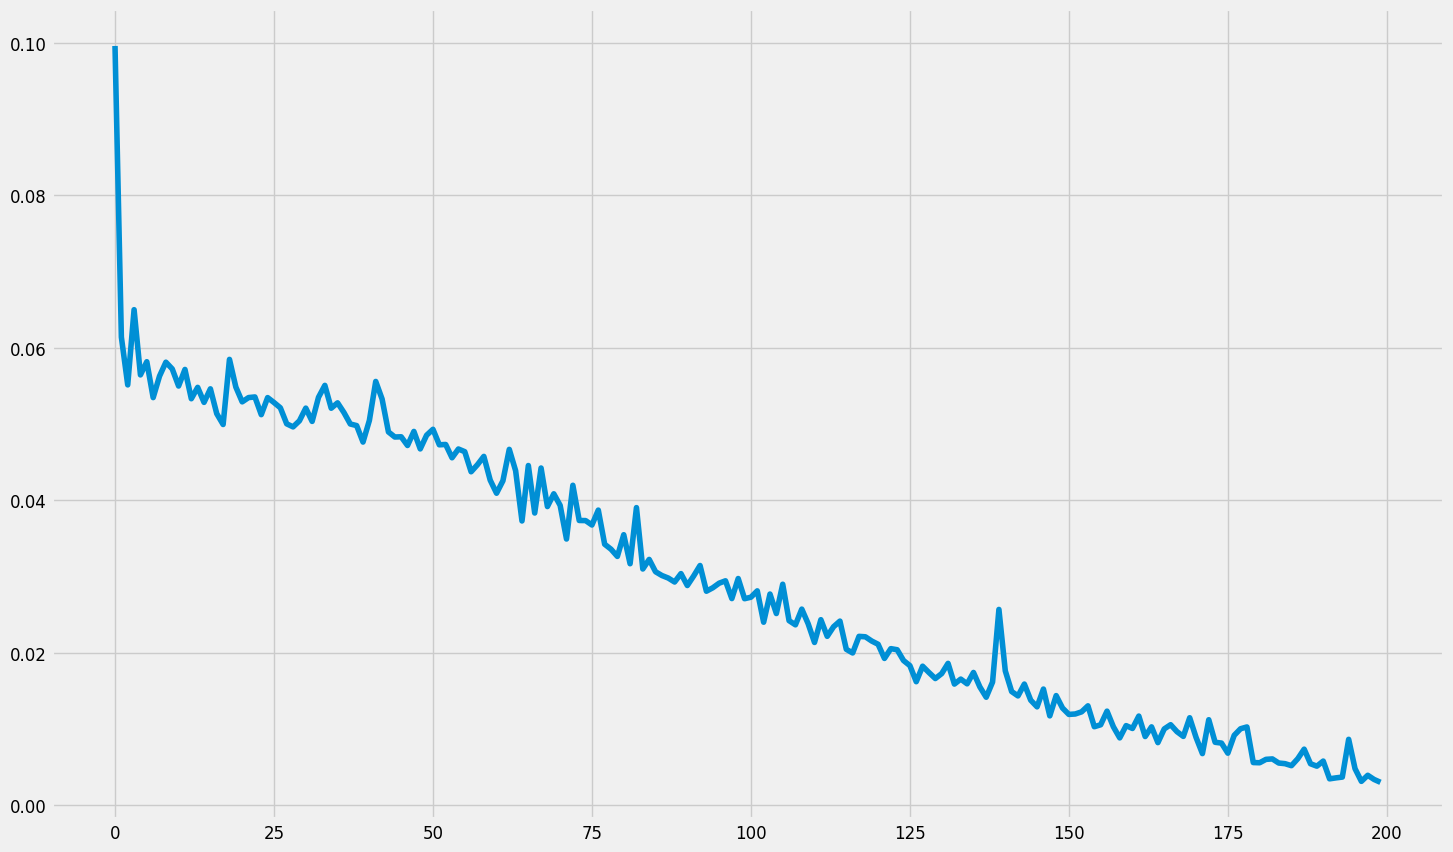

In [54]:
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)


In [55]:
# Último batch de treino
ultimo_batch_treino = scaled_treino[-6:]

In [56]:
# Ajusta o shape
ultimo_batch_treino = ultimo_batch_treino.reshape((1, n_input, n_features))

In [57]:
# Previsão em treino
modelo.predict(ultimo_batch_treino)

1/1 [==============================] - 0s 234ms/step


array([[0.60935855]], dtype=float32)

##PREVISOES EM TESTE E AVALIAÇÃO DO MODELO

In [58]:
previsoes_teste = []


In [59]:
# Primeiro batch
first_eval_batch = scaled_teste[-n_input:]

In [60]:
# Batch corrente
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [61]:
current_batch

array([[[0.36476075],
        [0.32272236],
        [0.39659367],
        [0.62956204],
        [0.63591511],
        [0.25885374]]])

In [62]:
dados_teste.head()


,Vendas
Mes,
2021-04-01,18316
2021-05-01,15190
2021-06-01,17727
2021-07-01,18434
2021-08-01,12483


In [63]:
# Loop de previsão
for i in range(len(dados_teste)):

    # Obtém o valor de previsão para o primeiro lote
    current_pred = modelo.predict(current_batch)[0]

    # Adiciona a previsão na matriz
    previsoes_teste.append(current_pred)

    # Usa a previsão para atualizar o lote e remover o primeiro valor
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 35ms/step


In [64]:
previsoes_teste

[array([0.27803373], dtype=float32),
 array([0.25439817], dtype=float32),
 array([0.23327237], dtype=float32),
 array([0.10737447], dtype=float32),
 array([0.1011901], dtype=float32),
 array([0.36098757], dtype=float32),
 array([0.714627], dtype=float32),
 array([0.98363507], dtype=float32),
 array([1.0349604], dtype=float32),
 array([0.7928262], dtype=float32),
 array([0.5982747], dtype=float32),
 array([0.90348625], dtype=float32)]

In [65]:
# Inverte a padronização
true_previsoes_teste = scaler.inverse_transform(previsoes_teste)

In [66]:
# Adiciona as previsões no dataframe de dados de teste
dados_teste['Previsao'] = true_previsoes_teste

In [67]:
dados_teste.head()


,Vendas,Previsao
Mes,,
2021-04-01,18316,13906.787119
2021-05-01,15190,13557.075281
2021-06-01,17727,13244.498041
2021-07-01,18434,11381.712723
2021-08-01,12483,11290.208685


In [68]:
dados_teste.tail()

,Vendas,Previsao
Mes,,
2021-11-01,14568,24346.864465
2021-12-01,15661,25106.273918
2022-01-01,19108,21523.656096
2022-02-01,19202,18645.072577
2022-03-01,13623,23160.982582


<Axes: xlabel='Mes'>

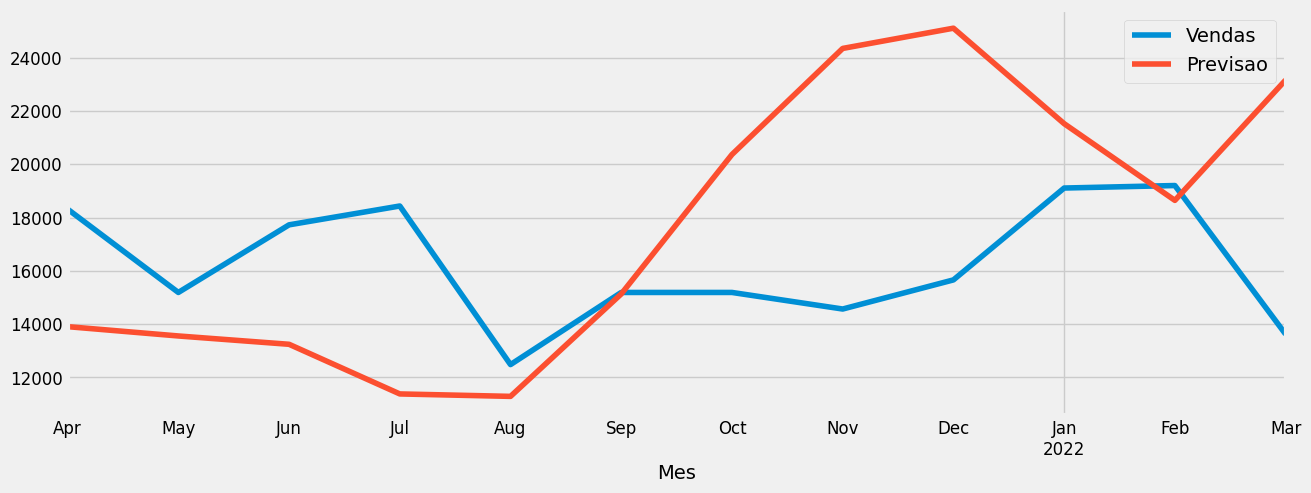

In [69]:
# Plot
dados_teste.plot(figsize = (14,5))

In [70]:
# Calcula o erro
rmse = sqrt(mean_squared_error(dados_teste['Vendas'], dados_teste['Previsao']))

In [71]:
print(rmse)

5788.757227764619
